In [5]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import imblearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, recall_score
from sklearn.model_selection import train_test_split

In [4]:
import os

folder_path = 'C:\\Users\\KK\\OneDrive\\Desktop\\Mini Proj\\Dataset'  
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

print(csv_files)


['Youtube01-Psy.csv', 'Youtube02-KatyPerry.csv', 'Youtube03-LMFAO.csv', 'Youtube04-Eminem.csv', 'Youtube05-Shakira.csv']


In [5]:
data = pd.read_csv("C:\\Users\\KK\\OneDrive\\Desktop\\Mini Proj\\Dataset\\Youtube04-Eminem.csv")

#data.info()
# Extract features and labels
X = data.iloc[:, 3].to_numpy()
y = data.iloc[:, 4].to_numpy()

# Split data into train and test sets
index_1 = np.where(y == 1)[0]
index_0 = np.where(y == 0)[0]

L1 = int(len(index_1) * 0.5)
L0 = int(len(index_0) * 0.5)

X_train_1 = X[index_1[:L1]]
y_train_1 = y[index_1[:L1]]
X_test_1 = X[index_1[L1:]]
y_test_1 = y[index_1[L1:]]

X_train_0 = X[index_0[:L0]]
y_train_0 = y[index_0[:L0]]
X_test_0 = X[index_0[L0:]]
y_test_0 = y[index_0[L0:]]

# Combine to make X_train, y_train, X_test, y_test
X_train = np.concatenate((X_train_1, X_train_0), axis=0)
y_train = np.concatenate((y_train_1, y_train_0), axis=0)

X_test = np.concatenate((X_test_1, X_test_0), axis=0)
y_test = np.concatenate((y_test_1, y_test_0), axis=0)

# Vectorize text data
corpus = data.iloc[:, 3]
vectorizer = TfidfVectorizer(stop_words=None, max_features=800).fit(corpus)
v_train = vectorizer.transform(X_train)
v_test = vectorizer.transform(X_test)


# Helper function to calculate metrics from confusion matrix
def calculate_metrics(cm):
    accuracy = (cm[1, 1] + cm[0, 0]) / (cm[1, 1] + cm[0, 0] + cm[0, 1] + cm[1, 0] + 1e-6)
    precision = cm[1, 1] / (cm[1, 1] + cm[0, 1] + 1e-6)
    recall = cm[1, 1] / (cm[1, 1] + cm[1, 0] + 1e-6)
    f1_score = 2 * cm[1, 1] / (2 * cm[1, 1] + cm[0, 1] + cm[1, 0] + 1e-6)
    return accuracy, precision, recall, f1_score

# Compute metrics for each model
accuracy = []
precision = []
recall = []
F1 = []
AUC = []



# Gaussian Naive Bayes

v_train_dense = v_train.toarray()
v_test_dense = v_test.toarray()

clf_nb = GaussianNB().fit(v_train_dense, y_train)
y_pred_nb = clf_nb.predict(v_test_dense)

# Confusion Matrix
cm_nb = confusion_matrix(y_test, y_pred_nb)

# Performance Metrics
acc_nb, prec_nb, rec_nb, f1_nb = calculate_metrics(cm_nb)
accuracy.append(acc_nb)
precision.append(prec_nb)
recall.append(rec_nb)
F1.append(f1_nb)
AUC.append(roc_auc_score(y_test, y_pred_nb))


# Logistic Regression

clf_lr = LogisticRegressionCV(Cs=list(np.power(10.0, np.arange(5, -6, -1))), cv=5, penalty='l2', scoring='roc_auc',
                           solver='newton-cg', max_iter=30000, random_state=0).fit(v_train, y_train)

i = np.where(clf_lr.scores_[1].mean(axis=0) == clf_lr.scores_[1].mean(axis=0).max())
i = int(i[0][0])  # Fix: Extract the first element from the array
Cs_select = list(np.power(10.0, np.arange(5, -6, -1)))[i]

clf_lr = LogisticRegression(random_state=0, C=Cs_select, penalty='l2', max_iter=30000).fit(v_train, y_train)
y_test_pred_lr = clf_lr.predict(v_test)
y_train_pred = clf_lr.predict(v_train)
# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_test_pred_lr)

# Performance Metrics
acc_lr, prec_lr, rec_lr, f1_lr = calculate_metrics(cm_lr)
accuracy.append(acc_lr)
precision.append(prec_lr)
recall.append(rec_lr)
F1.append(f1_lr)
AUC.append(roc_auc_score(y_test, y_test_pred_lr))



# MLP Classifier

# Instantiate the MLP classifier
mlp = MLPClassifier(
    hidden_layer_sizes=(220, 30),
    max_iter=200
)

# Train the classifier
mlp.fit(v_train, y_train)

# Make predictions on the test data
y_test_pred_mlp = mlp.predict(v_test)

# Confusion Matrix
cm_mlp = confusion_matrix(y_test, y_test_pred_mlp)

# Performance Metrics
acc_mlp, prec_mlp, rec_mlp, f1_mlp = calculate_metrics(cm_mlp)
accuracy.append(acc_mlp)
precision.append(prec_mlp)
recall.append(rec_mlp)
F1.append(f1_mlp)
AUC.append(roc_auc_score(y_test, y_test_pred_mlp))



# SVC Classifier

# Parameter grid for grid search
param_grid = {
    'C': [0.1, 1, 10],  # Adjust C values as needed
    'gamma': [0.1, 1, 10]  # Adjust gamma values as needed
}

# Instantiate the SVM classifier
svm = SVC()  # adjust hyperparameters later

# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(svm, param_grid, cv=5)  # Adjust cv (number of cross-validation folds)
grid_search.fit(v_train, y_train)

# Get the best hyperparameters
best_C = grid_search.best_params_['C']
best_gamma = grid_search.best_params_['gamma']

print("Best C:", best_C)
print("Best gamma:", best_gamma)

# Instantiate the SVC classifier with the best hyperparameters
svm_best = SVC(C=best_C, gamma=best_gamma)

# Train the classifier
svm_best.fit(v_train, y_train)

# Make predictions on the training data
y_train_pred = svm_best.predict(v_train)

# Make predictions on the test data
y_test_pred_svc = svm_best.predict(v_test)


# Confusion Matrix
cm_svc = confusion_matrix(y_test, y_test_pred_svc)

# Performance Metrics
acc_svc, prec_svc, rec_svc, f1_svc = calculate_metrics(cm_svc)
accuracy.append(acc_svc)
precision.append(prec_svc)
recall.append(rec_svc)
F1.append(f1_svc)
AUC.append(roc_auc_score(y_test, y_test_pred_svc))




# Create DataFrame for results
headings = ['Accuracy', 'Precision', 'AUC', 'F1', 'Recall']
names = ['NB-Gaussian', 'LogisticRegression', 'MLP Classifier', 'SVC Classifier']
numpy_data = np.array([accuracy, precision, AUC, F1, recall]).T  # Use correctly computed metrics

df = pd.DataFrame(data=numpy_data, index=names, columns=headings)

print('The Performance for Eminem is summarized in the following Table:')
display(df.style.highlight_max(color='lightgreen', axis=0))

data = pd.read_csv("C:\\Users\\KK\\OneDrive\\Desktop\\Mini Proj\\Dataset\\Youtube04-Eminem.csv")

#data.info()
# Extract features and labels
X = data.iloc[:, 3].to_numpy()
y = data.iloc[:, 4].to_numpy()

# Split data into train and test sets
index_1 = np.where(y == 1)[0]
index_0 = np.where(y == 0)[0]

L1 = int(len(index_1) * 0.5)
L0 = int(len(index_0) * 0.5)

X_train_1 = X[index_1[:L1]]
y_train_1 = y[index_1[:L1]]
X_test_1 = X[index_1[L1:]]
y_test_1 = y[index_1[L1:]]

X_train_0 = X[index_0[:L0]]
y_train_0 = y[index_0[:L0]]
X_test_0 = X[index_0[L0:]]
y_test_0 = y[index_0[L0:]]

# Combine to make X_train, y_train, X_test, y_test
X_train = np.concatenate((X_train_1, X_train_0), axis=0)
y_train = np.concatenate((y_train_1, y_train_0), axis=0)

X_test = np.concatenate((X_test_1, X_test_0), axis=0)
y_test = np.concatenate((y_test_1, y_test_0), axis=0)

# Vectorize text data
corpus = data.iloc[:, 3]
vectorizer = TfidfVectorizer(stop_words=None, max_features=800).fit(corpus)
v_train = vectorizer.transform(X_train)
v_test = vectorizer.transform(X_test)


# Helper function to calculate metrics from confusion matrix
def calculate_metrics(cm):
    accuracy = (cm[1, 1] + cm[0, 0]) / (cm[1, 1] + cm[0, 0] + cm[0, 1] + cm[1, 0] + 1e-6)
    precision = cm[1, 1] / (cm[1, 1] + cm[0, 1] + 1e-6)
    recall = cm[1, 1] / (cm[1, 1] + cm[1, 0] + 1e-6)
    f1_score = 2 * cm[1, 1] / (2 * cm[1, 1] + cm[0, 1] + cm[1, 0] + 1e-6)
    return accuracy, precision, recall, f1_score

# Compute metrics for each model
accuracy = []
precision = []
recall = []
F1 = []
AUC = []



# Decision Tree

# Instantiate the Decision Tree Classifier
decision_tree = DecisionTreeClassifier()

# Train the classifier
decision_tree.fit(v_train, y_train)

# Make predictions on the training data
y_train_pred = decision_tree.predict(v_train)

# Make predictions on the test data
y_test_pred_dt = decision_tree.predict(v_test)

# Confusion Matrix
cm_dt = confusion_matrix(y_test, y_test_pred_dt)

# Performance Metrics
acc_dt, prec_dt, rec_dt, f1_dt = calculate_metrics(cm_dt)
accuracy.append(acc_dt)
precision.append(prec_dt)
recall.append(rec_dt)
F1.append(f1_dt)
AUC.append(roc_auc_score(y_test, y_test_pred_dt))



# Random Forest CLassifier

# Parameter grid for grid search
param_grid = {
    'n_estimators': [20, 50, 75, 100, 150, 175, 180],
    'max_depth': [None, 10, 20, 30, 40, 50, 60]
}

# Instantiate the Random Forest Classifier
random_forest = RandomForestClassifier()

# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(random_forest, param_grid, cv=5)  # Adjust cv (number of cross-validation folds)
grid_search.fit(v_train, y_train)

# Get the best hyperparameters
best_n_estimators = grid_search.best_params_['n_estimators']
best_max_depth = grid_search.best_params_['max_depth']

print("Best n_estimators:", best_n_estimators)
print("Best max_depth:", best_max_depth)

# Instantiate the Random Forest Classifier with the best hyperparameters
random_forest_best = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=best_max_depth)

# Train the classifier
random_forest_best.fit(v_train, y_train)

# Make predictions on the training data
y_train_pred = random_forest_best.predict(v_train)

# Make predictions on the test data
y_test_pred_rf = random_forest_best.predict(v_test)

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_test_pred_rf)

# Performance Metrics
acc_rf, prec_rf, rec_rf, f1_rf = calculate_metrics(cm_rf)
accuracy.append(acc_rf)
precision.append(prec_rf)
recall.append(rec_rf)
F1.append(f1_rf)
AUC.append(roc_auc_score(y_test, y_test_pred_rf))



# KNN

# Instantiate the KNN classifier
knn = KNeighborsClassifier(n_neighbors=9)  # Adjust n_neighbors as needed

# Train the classifier
knn.fit(v_train, y_train)

# Make predictions on the training data
y_train_pred = knn.predict(v_train)

# Make predictions on the test data
y_test_pred_knn = knn.predict(v_test)

# Confusion Matrix
cm_knn = confusion_matrix(y_test, y_test_pred_knn)

# Performance Metrics
acc_knn, prec_knn, rec_knn, f1_knn = calculate_metrics(cm_knn)
accuracy.append(acc_knn)
precision.append(prec_knn)
recall.append(rec_knn)
F1.append(f1_knn)
AUC.append(roc_auc_score(y_test, y_test_pred_knn))



# Voting Classifier

# Define individual classifiers
knn_classifier = KNeighborsClassifier()
mlp_classifier = MLPClassifier()
svc_classifier = SVC(probability=True)
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()

# Create a Voting Classifier
voting_classifier = VotingClassifier(
    estimators=[
        ('knn', knn_classifier),
        ('mlp', mlp_classifier),
        ('svc', svc_classifier),
        ('decision_tree', decision_tree),
        ('random_forest', random_forest)
    ],
    voting='hard'
)

# Train the voting classifier
voting_classifier.fit(v_train, y_train)

# Make predictions on the training data
y_train_pred = voting_classifier.predict(v_train)

# Make predictions on the test data
y_test_pred_vc = voting_classifier.predict(v_test)

# Confusion Matrix
cm_vc = confusion_matrix(y_test, y_test_pred_vc)

# Performance Metrics
acc_vc, prec_vc, rec_vc, f1_vc = calculate_metrics(cm_vc)
accuracy.append(acc_vc)
precision.append(prec_vc)
recall.append(rec_vc)
F1.append(f1_vc)
AUC.append(roc_auc_score(y_test, y_test_pred_vc))


# Create DataFrame for results
headings = ['Accuracy', 'Precision', 'AUC', 'F1', 'Recall']
names = ['Decision Tree', 'Random Forest', 'KNN', 'Voting Classifier']
numpy_data = np.array([accuracy, precision, AUC, F1, recall]).T  # Use correctly computed metrics

df = pd.DataFrame(data=numpy_data, index=names, columns=headings)

print('The Performance for Eminem is summarized in the following Table:')
display(df.style.highlight_max(color='lightgreen', axis=0))


Best C: 1
Best gamma: 1
The Performance for Eminem is summarized in the following Table:


,Accuracy,Precision,AUC,F1,Recall
NB-Gaussian,0.884444,0.848921,0.876734,0.900763,0.959350
LogisticRegression,0.924444,0.934426,0.924199,0.930612,0.926829
MLP Classifier,0.897778,0.909836,0.897298,0.906122,0.902439
SVC Classifier,0.924444,0.941667,0.925036,0.930041,0.918699


Best n_estimators: 100
Best max_depth: 20
The Performance for Eminem is summarized in the following Table:


,Accuracy,Precision,AUC,F1,Recall
Decision Tree,0.915556,0.900000,0.911884,0.924901,0.951220
Random Forest,0.951111,0.991228,0.954448,0.953586,0.918699
KNN,0.897778,0.946429,0.901483,0.902128,0.861789
Voting Classifier,0.946667,0.974359,0.948709,0.950000,0.926829


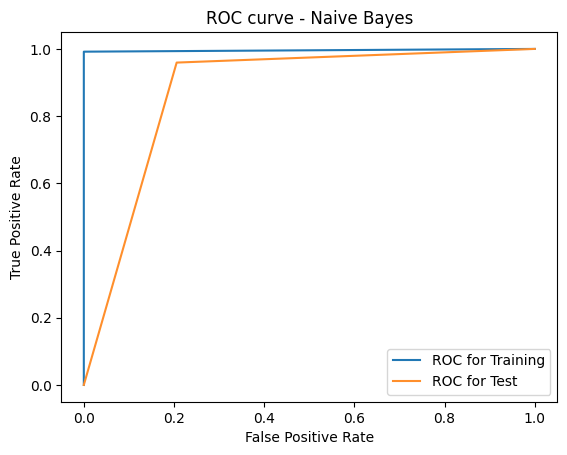

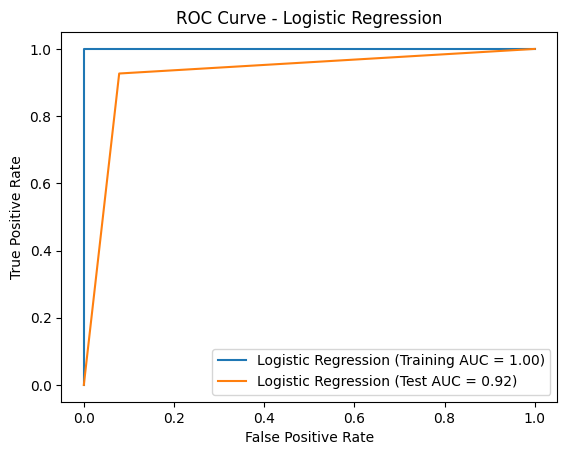

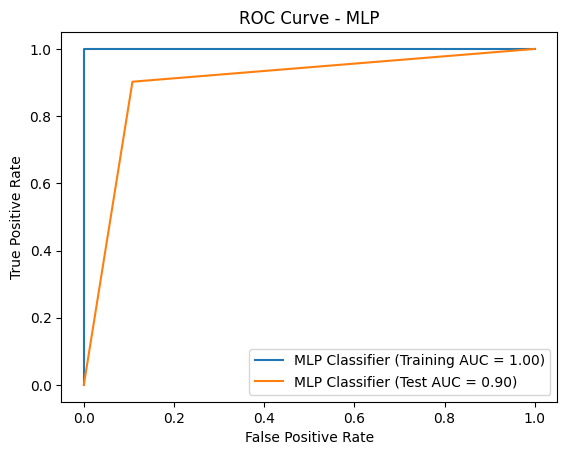

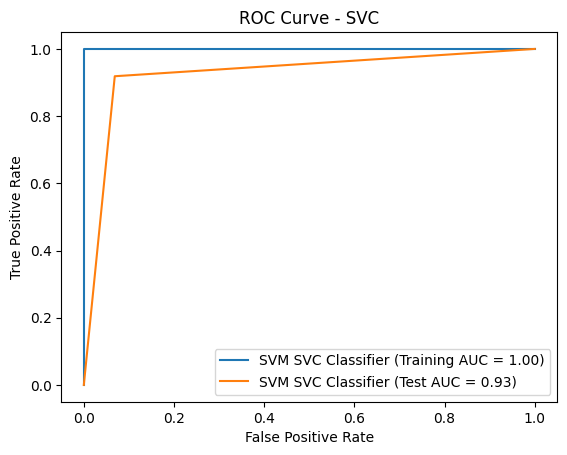

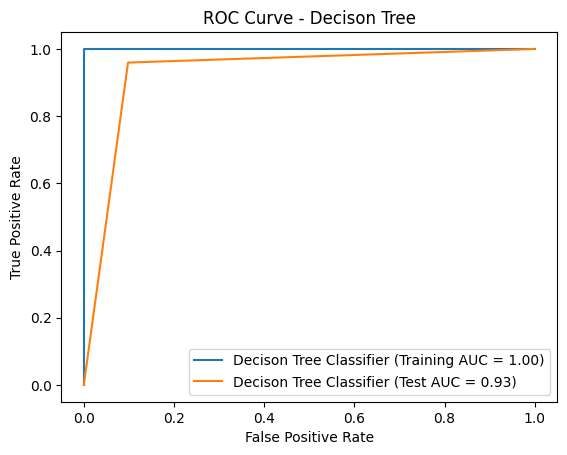

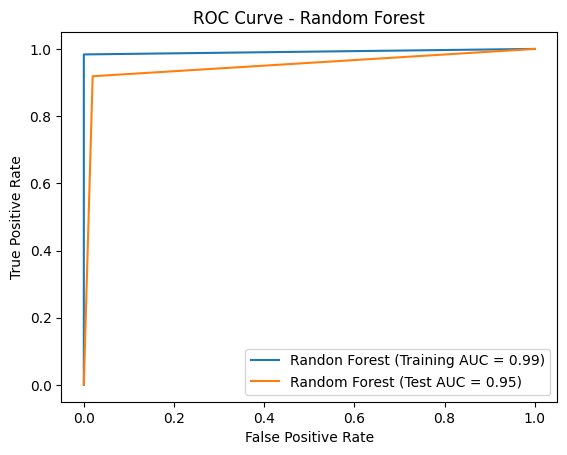

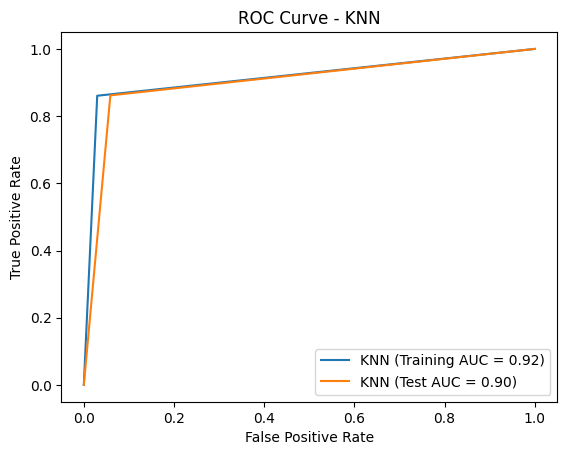

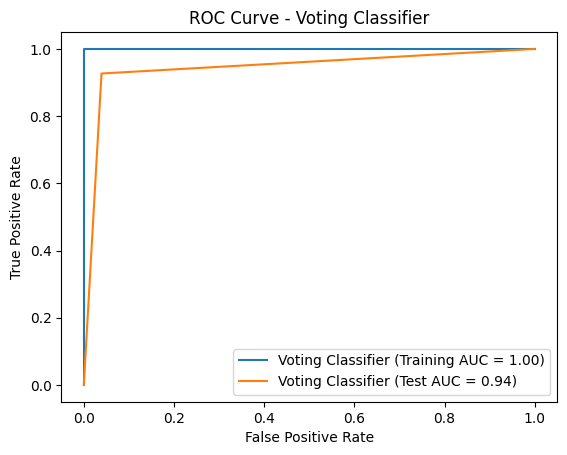

In [6]:
# Naive Bayes - ROC

v_train_dense = v_train.toarray()
v_test_dense = v_test.toarray()

clf_nb = GaussianNB().fit(v_train_dense, y_train)
y_pred_nb = clf_nb.predict(v_test_dense)
y_train_pred = clf_nb.predict(v_train_dense)

fpr0, tpr0, thresholds0 = roc_curve(y_train, y_train_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_nb)
plt.plot(fpr0, tpr0, '#2178b5', label='ROC for Training')
plt.plot(fpr, tpr, '#ff8f2c', label='ROC for Test')
plt.legend()

plt.title('ROC curve - Naive Bayes')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Logistic Regression - ROC Curve

y_test_pred_lr = clf_lr.predict(v_test)
y_train_pred = clf_lr.predict(v_train)

auc_roc_train = roc_auc_score(y_train, y_train_pred)
auc_roc_test = roc_auc_score(y_test, y_test_pred_lr)

# Plot the AUC-ROC curve for training data
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred)

# Plot the AUC-ROC curve for test data
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred_lr)


plt.figure()
plt.plot(fpr_train, tpr_train, label='Logistic Regression (Training AUC = %0.2f)' % auc_roc_train)
plt.plot(fpr_test, tpr_test, label='Logistic Regression (Test AUC = %0.2f)' % auc_roc_test)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.show()


# MLP - ROC

y_train_pred_proba = mlp.predict_proba(v_train)[:, 1]

y_test_pred_mlp_proba = mlp.predict_proba(v_test)

auc_roc_train = roc_auc_score(y_train, y_train_pred_proba)
auc_roc_test = roc_auc_score(y_test, y_test_pred_mlp)

# Plot the AUC-ROC curve for training data
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_proba)

# Plot the AUC-ROC curve for test data
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred_mlp)

plt.figure()
plt.plot(fpr_train, tpr_train, label='MLP Classifier (Training AUC = %0.2f)' % auc_roc_train)
plt.plot(fpr_test, tpr_test, label='MLP Classifier (Test AUC = %0.2f)' % auc_roc_test)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - MLP')
plt.legend(loc='lower right')
plt.show()


# SVC - ROC Curve

y_train_pred = svm_best.predict(v_train)

y_test_pred_svc = svm_best.predict(v_test)

auc_roc_train = roc_auc_score(y_train, y_train_pred)

auc_roc_test = roc_auc_score(y_test, y_test_pred_svc)

# Plot the AUC-ROC curve for training data
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred)

# Plot the AUC-ROC curve for test data
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred_svc)

plt.figure()
plt.plot(fpr_train, tpr_train, label='SVM SVC Classifier (Training AUC = %0.2f)' % auc_roc_train)
plt.plot(fpr_test, tpr_test, label='SVM SVC Classifier (Test AUC = %0.2f)' % auc_roc_test)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVC')
plt.legend(loc='lower right')
plt.show()

# Decison Tree - ROC Curve


decision_tree.fit(v_train, y_train)

# Make predictions on the training data
y_train_pred = decision_tree.predict(v_train)

# Make predictions on the test data
y_test_pred_dt = decision_tree.predict(v_test)

auc_roc_train = roc_auc_score(y_train, y_train_pred)

auc_roc_test = roc_auc_score(y_test, y_test_pred_dt)

# Plot the AUC-ROC curve for training data
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred)

# Plot the AUC-ROC curve for test data
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred_dt)

plt.figure()
plt.plot(fpr_train, tpr_train, label='Decison Tree Classifier (Training AUC = %0.2f)' % auc_roc_train)
plt.plot(fpr_test, tpr_test, label='Decison Tree Classifier (Test AUC = %0.2f)' % auc_roc_test)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decison Tree')
plt.legend(loc='lower right')
plt.show()

# Random Forest - ROC Curve

random_forest_best.fit(v_train, y_train)

# Make predictions on the training data
y_train_pred = random_forest_best.predict(v_train)

# Make predictions on the test data
y_test_pred_rf = random_forest_best.predict(v_test)

auc_roc_train = roc_auc_score(y_train, y_train_pred)

auc_roc_test = roc_auc_score(y_test, y_test_pred_rf)

# Plot the AUC-ROC curve for training data
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred)

# Plot the AUC-ROC curve for test data
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred_rf)

plt.figure()
plt.plot(fpr_train, tpr_train, label='Randon Forest (Training AUC = %0.2f)' % auc_roc_train)
plt.plot(fpr_test, tpr_test, label='Random Forest (Test AUC = %0.2f)' % auc_roc_test)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.show()

# KNN - ROC Curve

knn.fit(v_train, y_train)

# Make predictions on the training data
y_train_pred = knn.predict(v_train)

# Make predictions on the test data
y_test_pred_knn = knn.predict(v_test)

auc_roc_train = roc_auc_score(y_train, y_train_pred)

auc_roc_test = roc_auc_score(y_test, y_test_pred_knn)

# Plot the AUC-ROC curve for training data
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred)

# Plot the AUC-ROC curve for test data
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred_knn)

plt.figure()
plt.plot(fpr_train, tpr_train, label='KNN (Training AUC = %0.2f)' % auc_roc_train)
plt.plot(fpr_test, tpr_test, label='KNN (Test AUC = %0.2f)' % auc_roc_test)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - KNN')
plt.legend(loc='lower right')
plt.show()

# Voting Classifier - ROC Curve

voting_classifier.fit(v_train, y_train)

# Make predictions on the training data
y_train_pred = voting_classifier.predict(v_train)

# Make predictions on the test data
y_test_pred_vc = voting_classifier.predict(v_test)

auc_roc_train = roc_auc_score(y_train, y_train_pred)

auc_roc_test = roc_auc_score(y_test, y_test_pred_vc)

# Plot the AUC-ROC curve for training data
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred)

# Plot the AUC-ROC curve for test data
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred_vc)

plt.figure()
plt.plot(fpr_train, tpr_train, label='Voting Classifier (Training AUC = %0.2f)' % auc_roc_train)
plt.plot(fpr_test, tpr_test, label='Voting Classifier (Test AUC = %0.2f)' % auc_roc_test)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Voting Classifier')
plt.legend(loc='lower right')
plt.show()

In [7]:
from joblib import dump

# After training each model
dump(clf_nb, 'nb_model.joblib')
dump(clf_lr, 'lr_model.joblib')
dump(mlp, 'mlp_model.joblib')
dump(svm_best, 'svc_model.joblib')
dump(decision_tree, 'dt_model.joblib')
dump(random_forest_best, 'rf_model.joblib')
dump(knn, 'knn_model.joblib')
dump(voting_classifier, 'voting_model.joblib')

# Save vectorizer
dump(vectorizer, 'tfidf_vectorizer.joblib')


['tfidf_vectorizer.joblib']